In [1]:
# scPileupVars = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_chip_genes/CHIP_b1_Control/concat_scPileupVars/pileup.tsv"
# vcf = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/variants.all.vcf"
# outdir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/cells_vars/vcfpad_1/"
# vcf_pad = 1

vcf = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/variants.all.vcf"
scPileupVars = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/CHIP_b1_Control/concat_scPileupVars/pileup.tsv"
vcf_pad = 1
outdir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/CHIP_b1_Control/cells_vars/vcfpad_1"

#barcodes_f = "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_dec172021_b1/MTBlacklist_A2/Control/outs/filtered_peak_bc_matrix/barcodes.tsv"
#scPileupVars = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/old_v01_scPileupVars/"

In [2]:
from glob import glob
from os.path import basename, join
from src.utils.data_io import read_csv_multichar
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

fig_utils from mplh


In [3]:
pandarallel.initialize(nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
region_f = vcf+".region.txt"
vcf_df = read_csv_multichar(vcf, sep="\t", multicomment="##")
vcf_df[["#CHROM", "POS"]].to_csv(region_f, index=None, sep="\t", header=None)

#### The vcf file is 1-based, while the pileup positions are 0-based since they were from bam (pysam was the program used)
** Need to double check this

In [5]:
vcf_df = vcf_df.loc[vcf_df["#CHROM"].str.contains("^chr")]
vcf_df

vcf_df["posID"] = vcf_df["#CHROM"] + "_" + (vcf_df["POS"].astype(int)-vcf_pad).astype(str)
vcf_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,CHIP_b1_Control,...,CHIP_b2_Control,CHIP_b2_Flt3l,CHIP_b2_Input,CHIP_b3_Control,CHIP_b3_Flt3l,CHIP_b3_Input,CHIP_b4_Control,CHIP_b4_Flt3l,CHIP_b4_Input,posID
1000,chr1,10018,.,C,G,97.47380,.,TYPE=snv;NS=12;AF=0.08333333;DP=4744;RO=4722;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/0:0.2387064:681:678:1:0.001468429:402,276,1,...",...,"0/0:0:234:233:0:0:113,120,0,0:-1:-1:0:944.2852:.","0/0:0:225:225:0:0:113,112,0,0:-1:-1:0:926.5604:.","0/0:0:343:343:0:0:176,167,0,0:-1:-1:0:1432.95:.","0/0:16.98098:186:184:2:0.01075269:100,84,0,2:9...","0/0:0:269:269:0:0:130,139,0,0:-1:-1:0:1116.99:.","0/0:0:108:108:0:0:53,55,0,0:-1:-1:0:416.3386:.","0/0:21.71786:356:353:3:0.008426966:162,191,2,1...","0/0:0:315:314:0:0:160,154,0,0:-1:-1:0:1305.324:.","0/0:0:118:118:0:0:67,51,0,0:-1:-1:0:458.7915:.",chr1_10017
1001,chr1,10031,.,T,TA,65.50475,.,TYPE=ins;NS=12;AF=0.08333333;DP=6095;RO=6077;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/1:65.50475:856:853:5:0.005841121:532,321,3,2...",...,"0/0:0:315:315:0:0:163,152,0,0:-1:-1:0:1790.363:.","0/0:0:286:286:0:0:146,140,0,0:-1:-1:0:1616.495:.","0/0:0:432:431:0:0:237,194,0,0:-1:-1:0:2483.383:.","0/0:0:245:245:0:0:141,104,0,0:-1:-1:0:1386.389:.","0/0:0:357:357:0:0:189,168,0,0:-1:-1:0:2052.156:.","0/0:0:141:141:0:0:70,71,0,0:-1:-1:0:744.5862:.","0/0:0:446:444:0:0:230,214,0,0:-1:-1:0:2570.377:.","0/0:0:381:379:0:0:208,171,0,0:-1:-1:0:2196.873:.","0/0:0:154:153:0:0:94,59,0,0:-1:-1:0:833.2017:.",chr1_10030
1002,chr1,10039,.,AC,A,87.23672,.,TYPE=del;NS=12;AF=0.08333333;DP=6678;RO=6620;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/0:0:946:939:0:0:633,306,0,0:-1:-1:0:Inf:.",...,"0/0:0:341:340:0:0:195,145,0,0:-1:-1:0:1873.462:.","0/0:0:308:306:0:0:178,128,0,0:-1:-1:0:1679.652:.","0/0:0:472:470:0:0:277,193,0,0:-1:-1:0:2615.803:.","0/0:0:259:259:0:0:168,91,0,0:-1:-1:0:1403.992:.","0/0:22.05355:368:361:2:0.005434783:218,143,0,2...","0/0:0:161:160:0:0:94,66,0,0:-1:-1:0:819.4477:.","0/0:21.33713:492:489:2:0.004065041:288,201,2,0...","0/0:0:422:422:0:0:251,171,0,0:-1:-1:0:2310.822:.","0/0:0:176:174:0:0:124,50,0,0:-1:-1:0:933.9806:.",chr1_10038
1003,chr1,10051,.,A,ACCG,67.72425,.,TYPE=ins;NS=12;AF=0.08333333;DP=7730;RO=7680;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/0:0:1123:1117:0:0:754,363,0,0:-1:-1:0:Inf:.",...,"0/0:0:384:382:0:0:230,152,0,0:-1:-1:0:2286.389:.","0/0:0:348:348:0:0:212,136,0,0:-1:-1:0:2077.343:.","0/0:0:535:532:0:0:317,215,0,0:-1:-1:0:Inf:.","0/0:0:293:291:0:0:191,100,0,0:-1:-1:0:1747.041:.","0/0:0:419:416:0:0:272,144,0,0:-1:-1:0:2530.343:.","0/0:0:190:190:0:0:113,77,0,0:-1:-1:0:1078.799:.","0/0:0:562:561:0:0:346,215,0,0:-1:-1:0:Inf:.","0/0:0:456:456:0:0:289,167,0,0:-1:-1:0:2738.056:.","0/0:0:208:206:0:0:137,69,0,0:-1:-1:0:1201.061:.",chr1_10050
1004,chr1,10055,.,TA,T,60.01402,.,TYPE=del;NS=12;AF=0.1666667;DP=7734;RO=7677;AO...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/1:60.01402:1122:1113:9:0.00802139:707,406,4,...",...,"0/0:0:389:388:0:0:236,152,0,0:-1:-1:0:1570.522:.","0/0:0:352:352:0:0:216,136,0,0:-1:-1:0:1430.16:.","0/0:0.5660855:535:535:1:0.001869159:314,221,0,...","0/0:0:295:294:0:0:196,98,0,0:-1:-1:0:1183.517:.","0/0:0.5660855:422:421:1:0.002369668:270,151,0,...","0/0:0:189:186:0:0:107,79,0,0:-1:-1:0:730.9136:.","0/0:0:557:555:0:0:335,220,0,0:-1:-1:0:2283.826:.","0/0:0:451:449:0:0:288,161,0,0:-1:-1:0:1836.398:.","0/0:0:198:197:0:0:128,69,0,0:-1:-1:0:772.6831:.",chr1_10054


In [6]:
# pileup_files = glob(scPileupVars+"/*.bq.tsv")
# len(pileup_files)

In [7]:
pileup_df = pd.read_csv(scPileupVars,sep="\t", index_col=0)
pileup_df.head()

,chr,pos,nt,count,BQ,cell
0.0,chr1,66336079,G,1,37.0,AGTGTACCACCTGGTG-1
1.0,chr1,66336080,C,1,37.0,AGTGTACCACCTGGTG-1
2.0,chr1,66336081,C,1,37.0,AGTGTACCACCTGGTG-1
3.0,chr1,66336082,C,1,37.0,AGTGTACCACCTGGTG-1
4.0,chr1,66336083,A,1,37.0,AGTGTACCACCTGGTG-1


### When concatenating the column names were added too so need to drop those entries and convert the dtypes

In [8]:
print(pileup_df.shape)
pileup_df = pileup_df.loc[~((pileup_df["chr"] == "chr") & (pileup_df["nt"] == "nt"))].copy()
pileup_df.shape

(124121111, 6)


(124115782, 6)

In [9]:
pileup_df["posID"] = pileup_df["chr"] + "_" + pileup_df["pos"]
pileup_df = pileup_df.astype({"pos":int, "BQ": float, "count": int})
pileup_df["BQ"] = pileup_df["BQ"].astype(int)
pileup_df.dtypes

chr      object
pos       int64
nt       object
count     int64
BQ        int64
cell     object
posID    object
dtype: object

## Generate coverage for each pos

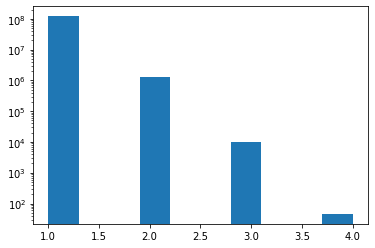

In [10]:
num_nts_each = pileup_df.groupby(["chr", "pos", "cell"]).size()
plt.hist(num_nts_each)
plt.yscale('log')

## Extract just the variants

In [11]:
vcf_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,CHIP_b1_Control,...,CHIP_b2_Control,CHIP_b2_Flt3l,CHIP_b2_Input,CHIP_b3_Control,CHIP_b3_Flt3l,CHIP_b3_Input,CHIP_b4_Control,CHIP_b4_Flt3l,CHIP_b4_Input,posID
1000,chr1,10018,.,C,G,97.47380,.,TYPE=snv;NS=12;AF=0.08333333;DP=4744;RO=4722;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/0:0.2387064:681:678:1:0.001468429:402,276,1,...",...,"0/0:0:234:233:0:0:113,120,0,0:-1:-1:0:944.2852:.","0/0:0:225:225:0:0:113,112,0,0:-1:-1:0:926.5604:.","0/0:0:343:343:0:0:176,167,0,0:-1:-1:0:1432.95:.","0/0:16.98098:186:184:2:0.01075269:100,84,0,2:9...","0/0:0:269:269:0:0:130,139,0,0:-1:-1:0:1116.99:.","0/0:0:108:108:0:0:53,55,0,0:-1:-1:0:416.3386:.","0/0:21.71786:356:353:3:0.008426966:162,191,2,1...","0/0:0:315:314:0:0:160,154,0,0:-1:-1:0:1305.324:.","0/0:0:118:118:0:0:67,51,0,0:-1:-1:0:458.7915:.",chr1_10017
1001,chr1,10031,.,T,TA,65.50475,.,TYPE=ins;NS=12;AF=0.08333333;DP=6095;RO=6077;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/1:65.50475:856:853:5:0.005841121:532,321,3,2...",...,"0/0:0:315:315:0:0:163,152,0,0:-1:-1:0:1790.363:.","0/0:0:286:286:0:0:146,140,0,0:-1:-1:0:1616.495:.","0/0:0:432:431:0:0:237,194,0,0:-1:-1:0:2483.383:.","0/0:0:245:245:0:0:141,104,0,0:-1:-1:0:1386.389:.","0/0:0:357:357:0:0:189,168,0,0:-1:-1:0:2052.156:.","0/0:0:141:141:0:0:70,71,0,0:-1:-1:0:744.5862:.","0/0:0:446:444:0:0:230,214,0,0:-1:-1:0:2570.377:.","0/0:0:381:379:0:0:208,171,0,0:-1:-1:0:2196.873:.","0/0:0:154:153:0:0:94,59,0,0:-1:-1:0:833.2017:.",chr1_10030
1002,chr1,10039,.,AC,A,87.23672,.,TYPE=del;NS=12;AF=0.08333333;DP=6678;RO=6620;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/0:0:946:939:0:0:633,306,0,0:-1:-1:0:Inf:.",...,"0/0:0:341:340:0:0:195,145,0,0:-1:-1:0:1873.462:.","0/0:0:308:306:0:0:178,128,0,0:-1:-1:0:1679.652:.","0/0:0:472:470:0:0:277,193,0,0:-1:-1:0:2615.803:.","0/0:0:259:259:0:0:168,91,0,0:-1:-1:0:1403.992:.","0/0:22.05355:368:361:2:0.005434783:218,143,0,2...","0/0:0:161:160:0:0:94,66,0,0:-1:-1:0:819.4477:.","0/0:21.33713:492:489:2:0.004065041:288,201,2,0...","0/0:0:422:422:0:0:251,171,0,0:-1:-1:0:2310.822:.","0/0:0:176:174:0:0:124,50,0,0:-1:-1:0:933.9806:.",chr1_10038
1003,chr1,10051,.,A,ACCG,67.72425,.,TYPE=ins;NS=12;AF=0.08333333;DP=7730;RO=7680;A...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/0:0:1123:1117:0:0:754,363,0,0:-1:-1:0:Inf:.",...,"0/0:0:384:382:0:0:230,152,0,0:-1:-1:0:2286.389:.","0/0:0:348:348:0:0:212,136,0,0:-1:-1:0:2077.343:.","0/0:0:535:532:0:0:317,215,0,0:-1:-1:0:Inf:.","0/0:0:293:291:0:0:191,100,0,0:-1:-1:0:1747.041:.","0/0:0:419:416:0:0:272,144,0,0:-1:-1:0:2530.343:.","0/0:0:190:190:0:0:113,77,0,0:-1:-1:0:1078.799:.","0/0:0:562:561:0:0:346,215,0,0:-1:-1:0:Inf:.","0/0:0:456:456:0:0:289,167,0,0:-1:-1:0:2738.056:.","0/0:0:208:206:0:0:137,69,0,0:-1:-1:0:1201.061:.",chr1_10050
1004,chr1,10055,.,TA,T,60.01402,.,TYPE=del;NS=12;AF=0.1666667;DP=7734;RO=7677;AO...,GT:QVAL:DP:RO:AO:AF:SB:SOR:RVSB:FS:QVAL_minAF:...,"0/1:60.01402:1122:1113:9:0.00802139:707,406,4,...",...,"0/0:0:389:388:0:0:236,152,0,0:-1:-1:0:1570.522:.","0/0:0:352:352:0:0:216,136,0,0:-1:-1:0:1430.16:.","0/0:0.5660855:535:535:1:0.001869159:314,221,0,...","0/0:0:295:294:0:0:196,98,0,0:-1:-1:0:1183.517:.","0/0:0.5660855:422:421:1:0.002369668:270,151,0,...","0/0:0:189:186:0:0:107,79,0,0:-1:-1:0:730.9136:.","0/0:0:557:555:0:0:335,220,0,0:-1:-1:0:2283.826:.","0/0:0:451:449:0:0:288,161,0,0:-1:-1:0:1836.398:.","0/0:0:198:197:0:0:128,69,0,0:-1:-1:0:772.6831:.",chr1_10054


In [12]:
pileup_vars_df = pileup_df.loc[pileup_df["posID"].isin(vcf_df["posID"])].copy()
pileup_vars_df

,chr,pos,nt,count,BQ,cell,posID
45.0,chr1,66336124,G,2,37,AGTGTACCACCTGGTG-1,chr1_66336124
61.0,chr1,66336140,C,2,37,AGTGTACCACCTGGTG-1,chr1_66336140
124.0,chr1,143214630,G,2,37,AGTGTACCACCTGGTG-1,chr1_143214630
157.0,chr1,143214665,T,2,31,AGTGTACCACCTGGTG-1,chr1_143214665
174.0,chr1,143214686,T,2,37,AGTGTACCACCTGGTG-1,chr1_143214686
...,...,...,...,...,...,...,...
22145.0,chrM,16485,A,5,37,CCCTAGTTCGCAAGCC-1,chrM_16485
22257.0,chrY,11312501,C,2,37,CCCTAGTTCGCAAGCC-1,chrY_11312501
22333.0,chrY,11312602,C,2,37,CCCTAGTTCGCAAGCC-1,chrY_11312602
22380.0,chrY,11312649,G,2,37,CCCTAGTTCGCAAGCC-1,chrY_11312649


In [ ]:
pileup_vars_df["coverage"] = pileup_vars_df.groupby(["chr", "pos", "cell"])["count"].transform(lambda x: sum(x))
pileup_vars_df["AF"] = pileup_vars_df["count"]/pileup_vars_df["coverage"]
pileup_vars_df.head()

In [ ]:
vcf_pos_df = vcf_df.set_index("posID")
vcf_pos_df = vcf_pos_df.loc[~(vcf_pos_df.index.duplicated())]
vcf_pos_df.head()

In [ ]:
pileup_vars_df["ref"] = pileup_vars_df.apply(lambda x: vcf_pos_df.loc[x["posID"], "REF"], axis=1)
pileup_vars_df.head()

In [ ]:
# print("Multi-allele positions")
# pileup_vars_df.loc[pileup_vars_df["count"]!=pileup_vars_df["coverage"]].sort_values(["cell", "posID"]).head(20)

## Keep the variants not ref

In [ ]:
vcf_df["ID"] = vcf_df.apply(lambda x: f"{x['posID']}_{x['ALT']}", axis=1)
assert(vcf_df.set_index("ID").index.duplicated().sum()==0)
vcf_df = vcf_df.set_index("ID")

In [ ]:
pileup_vars_df["ID"] = pileup_vars_df.apply(lambda x: f"{x['posID']}_{x['nt']}", axis=1)
pileup_vars_df.head()
                                            

In [ ]:
def is_var(entry, vcf_df):
    if entry["ID"] in vcf_df.index:
        return True
    return False 
#     curr_v = vcf_df.loc[(vcf_df["posID"] == entry["posID"]) & (vcf_df["ALT"] == entry["nt"])]
#     if len(curr_v)==1:
#         return True
#     elif len(curr_v)>1:
#         raise ValueError(f"more than one variant? {curr_v}")
#     return False
pileup_vars_df["isVar"] = pileup_vars_df.parallel_apply(is_var, args=(vcf_df,), axis=1)

In [ ]:
print(f"total bases including ref {pileup_vars_df.shape[0]}")
print(f"Variants detected {pileup_vars_df['isVar'].sum()}")

In [ ]:
pileup_vars_df[pileup_vars_df["isVar"]]

## Save

In [ ]:
pileup_vars_df[pileup_vars_df["isVar"]].to_csv(join(outdir, "af.pileup.tsv"), sep="\t")

In [ ]:
pileup_vars_df.to_csv(join(outdir, "af.ref.pileup.tsv"), sep="\t")